# Google Drive Interface Setup

In [2]:
from google.colab import drive, auth
import sys

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Pull down github repo, store in colab runtime memory
!git clone https://github.com/andrew-loeber/proj_utils_207.git

Cloning into 'proj_utils_207'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 34 (delta 10), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (34/34), 8.72 KiB | 4.36 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [5]:
# Tell Python to also look in this repo when running an import
sys.path.insert(1, "/content/proj_utils_207")

In [6]:
# Authenticate google account and give back the session access token
auth.authenticate_user()
gcloud_token = !gcloud auth print-access-token
gcloud_token

['ya29.a0AbVbY6PCGR0pKOJg2shKXpO2j86dECZvMQ_6fWQYme6JBmrVUur_WcLthnMweKDMAZig_5FOS_NKmPs7ZB19YAwpulp0bps9e3Mu9oTHS_Lwe700jwJzwLB1PGTjF9T1oViS4lGSUHU_mqW2Kqu8f8HgpIdsaCgYKATISARESFQFWKvPl3tiO0DoZTuCTKcx3pPYaAw0163']

In [7]:
from gdriveinterface import GDriveInterface
import proj_ref

In [8]:
# Show email address, username, and the path of the shared project folder on
# your Google Drive instance
gdi = GDriveInterface(gcloud_token)
shared_folder_path = gdi.shared_folder_path
gdi.__dict__

{'email': 'aloeber@berkeley.edu',
 'account': 'aloeber',
 'shared_folder_path': '/content/drive/MyDrive/207-Project'}

In [9]:
# Show name keys and paths for tracked files
proj_ref.files

{'taxonomy': 'BirdCLEF/eBird_Taxonomy_v2021.csv',
 'orig_metadata': 'BirdCLEF/train_metadata_with_duration.csv',
 'sample_metadata': 'data/sample_metadata.csv',
 'species_metadata': 'data/species_metadata.csv',
 'train_metadata': 'data/train_metadata.csv',
 'test_metadata': 'data/test_metadata.csv'}

In [10]:
# Show name keys and paths for tracked directories
proj_ref.dirs

{'orig_audio': {'path': 'BirdCLEF/train_audio'},
 'train_audio': {'path': 'data/train/audio_files'},
 'test_audio': {'path': 'data/test/audio_files'},
 'train_npy_full': {'path': 'data/train/librosa_loaded'},
 'test_npy_full': {'path': 'data/test/librosa_loaded'},
 'train_npy_loud5s': {'path': 'data/train/librosa_loaded_loudest_5sec'},
 'test_npy_loud5s': {'path': 'data/test/librosa_loaded_loudest_5sec'}}

### **Usage examples**

##### Query specific file based on named key
```
command: gdi.get_file_path('taxonomy')
returns: '/content/drive/MyDrive/207-Project/BirdCLEF/eBird_Taxonomy_v2021.csv'
```

##### Query specific directory based on named key
```
command: gdi.get_dir_path('orig_audio')
returns: '/content/drive/MyDrive/207-Project/BirdCLEF/train_audio'
```

##### Query specific sample record based on named keys for directory and file
```
command: gdi.get_sample_path('train_audio', 'barswa/XC132406.ogg')
returns: '/content/drive/MyDrive/207-Project/data/train/audio_files/barswa/XC132406.ogg'
```

##### Provide full path given a custom partial path
```
command: gdi.join_to_shared('images/sandpiper.jpeg')
returns: '/content/drive/MyDrive/207-Project/images/sandpiper.jpeg'
```


# Imports and Setup

In [11]:
!pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.8 MB/s eta 0:00:00


In [12]:
!pip install colorednoise

In [13]:
# !pip install tensorflow-addons

In [14]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
# import tensorflow_addons as tfa
import librosa
from IPython.display import Audio
import audiomentations as am
import colorednoise as cn
import gc

In [15]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Read in metadata, audio files, frames, & labels

In [16]:
train_file_df = pd.read_csv(
    gdi.join_to_shared('3_species/train/file_df.csv')
)
train_file_df

,data,primary_label,primary_label_enc,filename,filename_npy,rating,type,type_enc,country,country_enc,continent,continent_enc,file_duration_s,file_duration_samples
0,train,comsan,1,comsan/XC746957.ogg,comsan/XC746957.npy,good,blank,0,DK,15,EUROPE,3,6.112000,97792
1,train,eaywag1,2,eaywag1/XC658750.ogg,eaywag1/XC658750.npy,good,call,2,DE,14,EUROPE,3,49.680000,794880
2,train,comsan,1,comsan/XC725160.ogg,comsan/XC725160.npy,good,blank,0,EE,16,EUROPE,3,6.635000,106160
3,train,comsan,1,comsan/XC430908.ogg,comsan/XC430908.npy,good,call,2,RU,46,EUROPE,3,15.255500,244088
4,train,eaywag1,2,eaywag1/XC507677.ogg,eaywag1/XC507677.npy,poor,call,2,GB,20,EUROPE,3,17.397562,278361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,train,comsan,1,comsan/XC432940.ogg,comsan/XC432940.npy,good,call,2,NL,41,EUROPE,3,12.408000,198528
653,train,comsan,1,comsan/XC199825.ogg,comsan/XC199825.npy,good,call,2,ES,17,EUROPE,3,8.376000,134016
654,train,eaywag1,2,eaywag1/XC687206.ogg,eaywag1/XC687206.npy,good,call,2,IE,26,EUROPE,3,152.633000,2442128
655,train,eaywag1,2,eaywag1/XC591908.ogg,eaywag1/XC591908.npy,good,call,2,PL,44,EUROPE,3,14.616000,233856


In [17]:
train_labels = np.load(gdi.join_to_shared('3_species/train/file_labels.npy'))
train_labels[0:5]

array([1, 2, 1, 1, 2])

In [18]:
train_labels.shape

(657,)

In [19]:
# train_frames = np.load(gdi.join_to_shared('3_species/train/frames.npy'))
# train_frames[0:5]

In [20]:
# train_frames.shape

In [21]:
train_files_filepath = gdi.join_to_shared('3_species/train/files.pkl')
with open(train_files_filepath, 'rb') as file:
  train_files = pkl.load(file)
train_files[0:5]

[array([ 5.9499580e-06, -1.0428121e-05, -2.0700150e-05, ...,
        -1.4326214e-02, -1.2398371e-02, -1.4604669e-02], dtype=float32),
 array([-1.1132361e-06,  4.6719542e-06, -4.7960584e-06, ...,
        -7.4155294e-05, -4.1194289e-07,  9.1129157e-05], dtype=float32),
 array([-2.3218287e-05, -7.0027181e-06,  2.3201643e-05, ...,
        -6.9095149e-06, -2.1964188e-06,  5.6537119e-06], dtype=float32),
 array([ 1.0609627e-05,  4.7013164e-06,  6.1467290e-07, ...,
        -7.4523976e-03, -9.0304529e-03, -1.1077991e-02], dtype=float32),
 array([ 1.00838915e-05, -1.91047661e-06,  2.31165677e-06, ...,
        -9.90291737e-05,  2.73336598e-04, -1.12968672e-04], dtype=float32)]

In [22]:
train_files = [file - np.mean(file) for file in train_files.copy()]
train_files[0:5]

[array([ 0.00204584,  0.00202946,  0.00201919, ..., -0.01228633,
        -0.01035848, -0.01256478], dtype=float32),
 array([-1.1120907e-06,  4.6730997e-06, -4.7949129e-06, ...,
        -7.4154152e-05, -4.1079747e-07,  9.1130300e-05], dtype=float32),
 array([-2.3099887e-05, -6.8843183e-06,  2.3320043e-05, ...,
        -6.7911151e-06, -2.0780190e-06,  5.7721118e-06], dtype=float32),
 array([ 6.4127235e-05,  5.8218928e-05,  5.4132284e-05, ...,
        -7.3988801e-03, -8.9769354e-03, -1.1024473e-02], dtype=float32),
 array([ 1.0048502e-05, -1.9458657e-06,  2.2762677e-06, ...,
        -9.9064564e-05,  2.7330121e-04, -1.1300406e-04], dtype=float32)]

In [23]:
train_sizes = np.array(train_file_df['file_duration_samples'])
train_sizes[0:10]

array([  97792,  794880,  106160,  244088,  278361,  325172, 1077081,
        461568,  714704, 4829519])

In [24]:
train_durations = np.array(train_file_df['file_duration_s'])
train_durations[:10]

array([  6.112     ,  49.68      ,   6.635     ,  15.2555    ,
        17.3975625 ,  20.32325   ,  67.3175625 ,  28.848     ,
        44.669     , 301.84490625])

In [25]:
# train_sample_wts = np.array([ ((dur - 5.0) / 2.5) + 1 for dur in train_durations ])
# train_sample_wts /= np.mean(train_sample_wts)
# train_sample_wts

In [26]:
# train_sample_weights = np.array(train_file_df['file_duration_s'])
# train_sample_weights /= np.mean(train_sample_weights)
# train_sample_weights[0:10]

In [27]:
val_frame_df = pd.read_csv(
    gdi.join_to_shared('3_species/val/frame_df.csv')
)
val_frame_df

,data,primary_label,primary_label_enc,filename,filename_npy,rating,type,type_enc,country,country_enc,continent,continent_enc,file_duration_s,file_duration_samples,frame_length_s,hop_length_s,total_frames,frame_id
0,val,comsan,1,comsan/XC669042.ogg,comsan/XC669042.npy,good,call,2,HR,23,EUROPE,3,14.367000,229872,5.0,2.5,4,1
1,val,comsan,1,comsan/XC669042.ogg,comsan/XC669042.npy,good,call,2,HR,23,EUROPE,3,14.367000,229872,5.0,2.5,4,2
2,val,comsan,1,comsan/XC669042.ogg,comsan/XC669042.npy,good,call,2,HR,23,EUROPE,3,14.367000,229872,5.0,2.5,4,3
3,val,comsan,1,comsan/XC669042.ogg,comsan/XC669042.npy,good,call,2,HR,23,EUROPE,3,14.367000,229872,5.0,2.5,4,4
4,val,barswa,0,barswa/XC57672.ogg,barswa/XC57672.npy,good,song,3,UNKNOWN,55,UNKNOWN,4,40.960000,655360,5.0,2.5,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,val,barswa,0,barswa/XC184418.ogg,barswa/XC184418.npy,good,both,1,KZ,34,ASIA,2,60.473469,967576,5.0,2.5,23,19
3117,val,barswa,0,barswa/XC184418.ogg,barswa/XC184418.npy,good,both,1,KZ,34,ASIA,2,60.473469,967576,5.0,2.5,23,20
3118,val,barswa,0,barswa/XC184418.ogg,barswa/XC184418.npy,good,both,1,KZ,34,ASIA,2,60.473469,967576,5.0,2.5,23,21
3119,val,barswa,0,barswa/XC184418.ogg,barswa/XC184418.npy,good,both,1,KZ,34,ASIA,2,60.473469,967576,5.0,2.5,23,22


In [28]:
val_frame_labels = np.load(gdi.join_to_shared('3_species/val/frame_labels.npy'))
val_frame_labels[0:5]

array([1, 1, 1, 1, 0])

In [29]:
val_frame_labels.shape

(3121,)

In [30]:
val_frames = np.load(gdi.join_to_shared('3_species/val/frames.npy'))
val_frames[0:5]

array([[-2.70812802e-06,  2.27731789e-06,  6.10671464e-07, ...,
         4.44087666e-04, -1.34347146e-02,  4.17729001e-03],
       [ 1.13037531e-03,  4.36404441e-03,  5.12790517e-04, ...,
        -3.71276285e-04,  3.11362371e-03, -1.08309905e-03],
       [ 1.22987926e-02, -7.29914336e-03, -5.96568920e-03, ...,
        -2.97210005e-04, -2.47759186e-03, -2.29351601e-04],
       [ 1.11260731e-03,  3.40224011e-04, -8.38086358e-04, ...,
         2.87609873e-03, -4.81321616e-03,  1.80263212e-03],
       [ 3.00267129e-06, -6.75930642e-06, -2.86684372e-06, ...,
        -1.03749875e-02, -9.73683130e-03, -7.67644681e-03]], dtype=float32)

In [31]:
val_frames.shape

(3121, 80000)

# Define helper functions

In [117]:
def get_random_clip(
    audio
    , rng
    , clip_len=80000
    ):
  audio_len = len(audio)
  clip_start = rng.integers(audio_len - clip_len)
  clip_locs = (clip_start, clip_start + clip_len)
  return audio[clip_locs[0] : clip_locs[1]].copy()


In [ ]:
def audio_to_stft(
    audio
    , n_fft=128
    , hop_length=64):

  S = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
  S = np.abs(S)
  S_min, S_max = np.min(S), np.max(S)
  S_range = S_max - S_min
  return (S - S_min) / S_range

In [ ]:
def audio_to_db_stft(
    audio
    , n_fft=128
    , hop_length=64):

  S = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
  S = np.abs(S)
  S = librosa.amplitude_to_db(S, ref=np.max)
  S -= np.mean(S)
  S /= np.std(S)
  return S

In [142]:
def audio_to_mfcc(
    audio
    , sr=16000
    , hop_length=64
    , n_mfcc=32
    , lifter=32
    , fmin=200
    ):

  M = librosa.feature.mfcc(
    y=audio
    , sr=sr
    , hop_length=hop_length
    , n_mfcc=n_mfcc
    , lifter=lifter
    , fmin=fmin
  )
  M -= np.mean(M)
  M /= np.std(M)
  return M


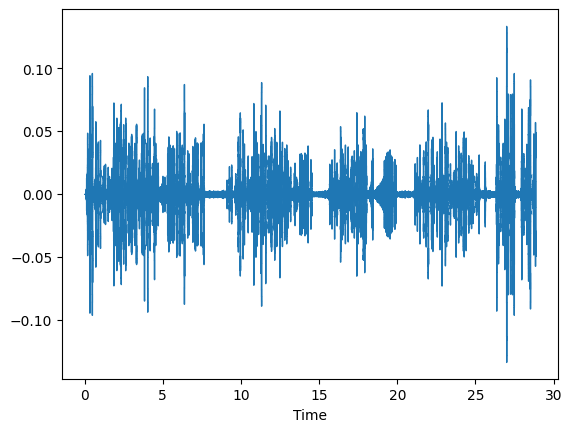

In [80]:
sample_audio = train_files[7] - np.mean(train_files[7])
librosa.display.waveshow(sample_audio, sr=16000)

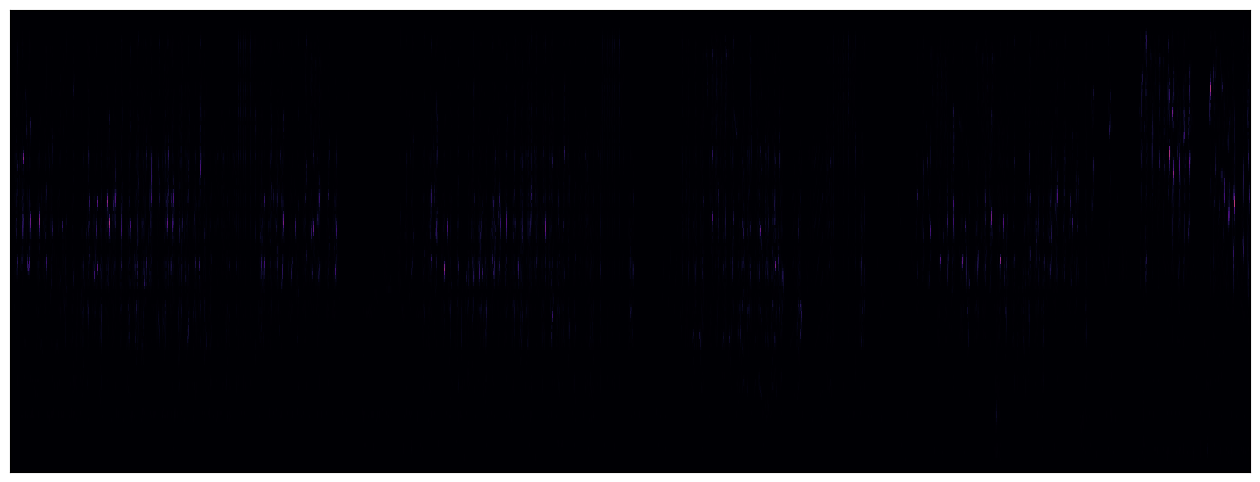

In [81]:
plt.figure(figsize=(16,6))
S = librosa.stft(
    y=sample_audio
    , hop_length=64
    , n_fft=256)

S_abs = np.abs(S)

librosa.display.specshow(S_abs)

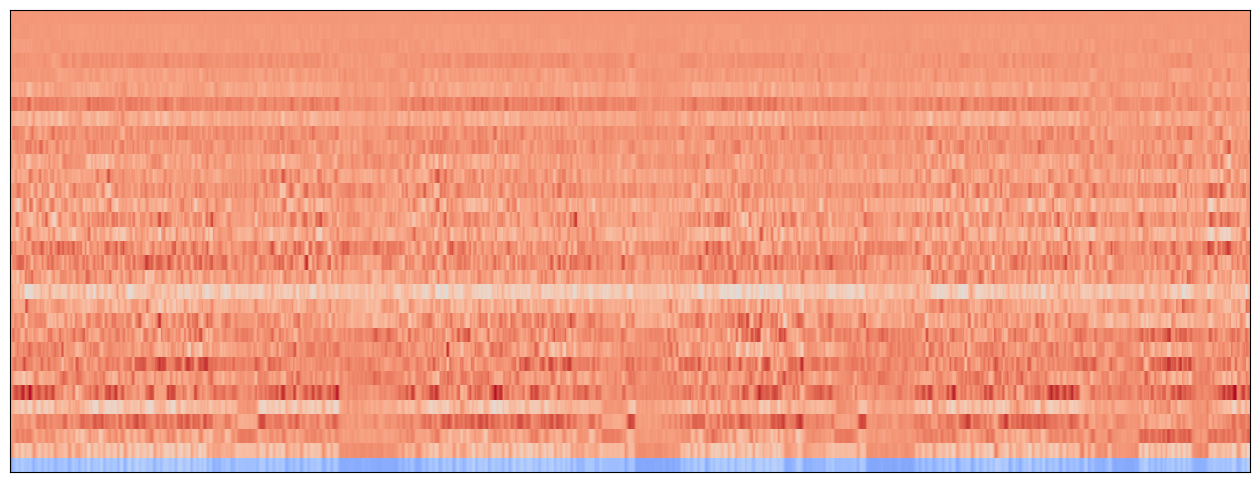

In [90]:
plt.figure(figsize=(16,6))
mfcc = librosa.feature.mfcc(
    y=sample_audio
    , sr=16000
    , hop_length=64
    , n_mfcc=32
    # , n_mels=128
    , fmin=200
    , lifter=32)

librosa.display.specshow(mfcc)

In [123]:
mfcc.shape

(32, 7213)

In [97]:
def transform_frames(frames, transform, transform_args):
  return np.array([transform(frame.copy(), **transform_args) for frame in frames])

def transform_frame(frame, transform, transform_args):
  return transform(frame.copy(), **transform_args)

In [98]:
def audio_compress(samples, sample_rate, mu_min=1, mu_max=17):
  mu = np.random.uniform(low=mu_min, high=mu_max)
  return librosa.mu_compress(samples, mu=mu, quantize=False)

def audio_expand(samples, sample_rate, mu_min=1, mu_max=17):
  mu = np.random.uniform(low=mu_min, high=mu_max)
  return librosa.mu_expand(samples, mu=mu, quantize=False)

def add_silent_frames(samples, sample_rate, p_min=5e-5, p_max=1e-2):
  p_min_log, p_max_log = np.log(p_min), np.log(p_max)
  prob_log = np.random.uniform(low=p_min_log, high=p_max_log)
  prob = np.exp(prob_log)
  mask = np.random.binomial(n=1, p=1-prob, size=len(samples))
  return (mask * samples).astype(np.float32)

def add_crackle(samples, sample_rate, p_min=1e-5, p_max=2e-4):
  p_min_log, p_max_log = np.log(p_min), np.log(p_max)
  prob_log = np.random.uniform(low=p_min_log, high=p_max_log)
  prob = np.exp(prob_log)
  mask = np.random.binomial(n=1, p=prob, size=len(samples))
  noise = np.random.binomial(n=1, p=0.5, size=len(samples)) * 2 - 1
  return np.where(mask, noise, samples).astype(np.float32)

def add_colored_noise(
    samples
    , sample_rate
    , exp_min=-4
    , exp_max=2
    , scale_min=0.005
    , scale_max=0.025
    ):
  exp = np.random.uniform(low=exp_min, high=exp_max)
  scale = np.random.uniform(low=scale_min, high=scale_max)
  noise = cn.powerlaw_psd_gaussian(exp, size=len(samples))
  return samples + (scale * noise)

def add_colored_noise2(
    samples
    , sample_rate
    , min_gain_db=-18.0
    , max_gain_db=18.0
    , scale_min=0.005
    , scale_max=0.05
    ):
  eq = am.SevenBandParametricEQ(
      min_gain_db=min_gain_db
      , max_gain_db=max_gain_db
      , p=1.0
  )
  norm = am.Normalize(p=1.0)
  scale = np.random.uniform(low=scale_min, high=scale_max)
  noise = np.random.randn(len(samples))
  noise = eq(noise, sample_rate=sample_rate)
  noise = norm(noise, sample_rate=sample_rate)
  return samples + (scale * noise)

# Processing

In [99]:
%who

Audio	 GDriveInterface	 S	 S_abs	 add_colored_noise	 add_colored_noise2	 add_crackle	 add_silent_frames	 am	 
audio_compress	 audio_expand	 audio_to_mfcc	 auth	 cn	 drive	 file	 gc	 gcloud_token	 
gdi	 layers	 librosa	 mfcc	 np	 pd	 pkl	 plt	 proj_ref	 
sample_audio	 shared_folder_path	 sns	 sys	 tf	 train_durations	 train_file_df	 train_files	 train_files_filepath	 
train_labels	 train_sizes	 transform_frame	 transform_frames	 val_frame_df	 val_frame_labels	 val_frames	 


In [143]:
gc.collect()

760

In [144]:
transform = audio_to_mfcc
transform_args = {}

In [145]:
val_features = transform_frames(val_frames, transform, transform_args)
val_features.shape

(3121, 32, 1251)

In [ ]:
# del val_frames

In [146]:
gc.collect()

0

In [ ]:
# plt.figure(figsize=(18,4))
# librosa.display.specshow(
#     val_features[1052,:,:]
#     , x_axis='time'
#     , y_axis='linear'
#     , sr=16000
#     , hop_length=64
# )

In [147]:
aug = am.Compose([
    # am.PitchShift(-2, 2, 0.25)
    # , am.Shift(-0.15, 0.15, False, p=1.0)
    am.Normalize(p=1.0)
    , am.OneOf([
        am.Lambda(transform=audio_compress, mu_min=1, mu_max=7, p=0.3)
        , am.Lambda(transform=audio_expand, mu_min=1, mu_max=11, p=0.3)
    ])

    , am.PeakingFilter(100, 2000, -12, 12, 1.0, 5.0, p=0.35)
    , am.PeakingFilter(2000, 4000, -12, 12, 1.0, 5.0, p=0.35)
    , am.PeakingFilter(4000, 6000, -12, 12, 1.0, 5.0, p=0.35)
    , am.PeakingFilter(6000, 7500, -12, 12, 1.0, 5.0, p=0.35)
    , am.LowPassFilter(4000, 7000, 6, 18, p=0.35)
    , am.HighPassFilter(100, 2000, 6, 18, p=0.35)

    , am.TimeMask(0.01, 0.1, p=0.5)
    , am.TimeMask(0.01, 0.1, p=0.5)
    , am.TimeMask(0.01, 0.1, p=0.5)
    , am.TimeMask(0.01, 0.1, p=0.5)
    , am.TimeMask(0.01, 0.1, p=0.5)

    , am.Lambda(
        transform=add_colored_noise2
        , min_gain_db=-15.0
        , max_gain_db=15.0
        , scale_min=0.005
        , scale_max=0.1
        , p=0.65
    )

    # , am.PeakingFilter(1000, 7000, -50, -38, 1, 2, 0.5)

    , am.Normalize(p=1.0)
    , am.Lambda(transform=add_silent_frames, p=0.2)
    , am.Lambda(transform=add_crackle, p=0.2)
])

In [148]:
sample_audio_num = 1055
val_frame_df.iloc[sample_audio_num]

data                                     val
primary_label                         barswa
primary_label_enc                          0
filename                 barswa/XC457823.ogg
filename_npy             barswa/XC457823.npy
rating                                  good
type                                    call
type_enc                                   2
country                                   RU
country_enc                               46
continent                             EUROPE
continent_enc                              3
file_duration_s                       28.176
file_duration_samples                 450816
frame_length_s                           5.0
hop_length_s                             2.5
total_frames                              10
frame_id                                   2
Name: 1055, dtype: object

In [149]:
sample_audio = val_frames[sample_audio_num]
sample_audio

array([-0.00083433, -0.02356659,  0.00866812, ..., -0.00054706,
        0.00162184,  0.00188546], dtype=float32)

In [150]:
Audio(sample_audio, rate=16000, autoplay=True)

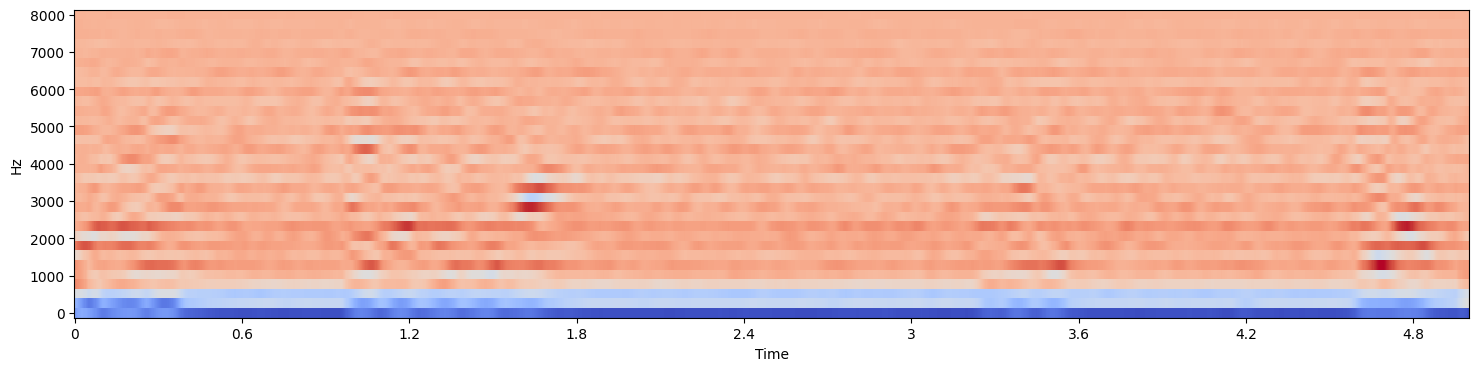

In [151]:
sample_spec = transform_frame(sample_audio, transform, transform_args)
# sample_spec = audio_to_db_stft(sample_audio, n_fft=128, hop_length=64)
plt.figure(figsize=(18,4))
librosa.display.specshow(
    sample_spec
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=64
)

In [156]:
#sample_audio_aug = am.LowPassFilter(200, 4000, 12, 24, p=1.0)(sample_audio, 16000)
sample_audio_aug = aug(sample_audio, 16000)
Audio(sample_audio_aug, rate=16000, autoplay=True)

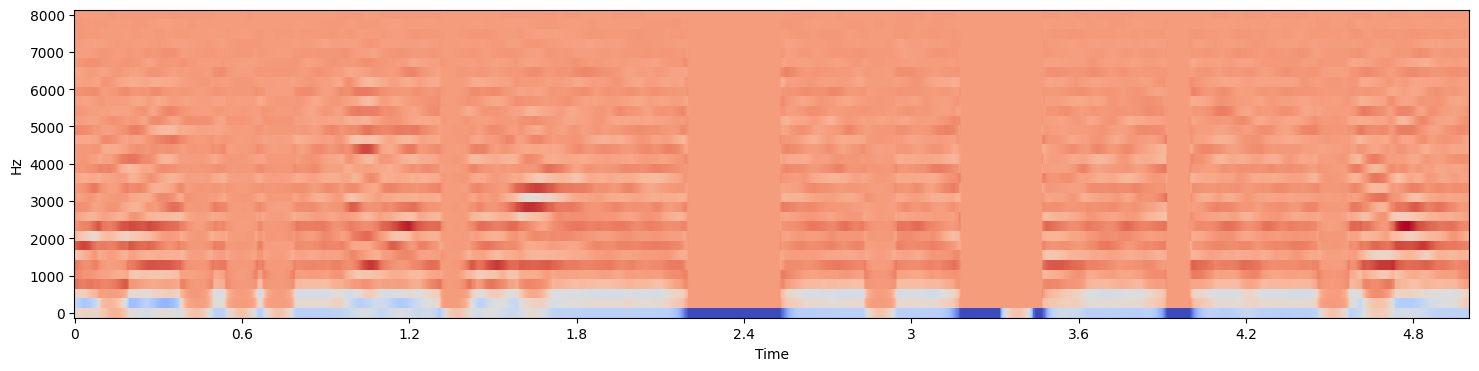

In [157]:
sample_spec_aug = transform_frame(sample_audio_aug, transform, transform_args)
plt.figure(figsize=(18,4))
librosa.display.specshow(
    sample_spec_aug
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=64
)

# Define audio sequence

In [158]:
class AudioSequence(tf.keras.utils.Sequence):
  def __init__(self
               , x
               , y
               , batch_size
               , feature_transform
               , feature_transform_args
               , durations=None
               , augmentation=None
               , shuffle=True
               , seed=42):
    self.x, self.y, self.durations = x, y, durations
    self.data_length = len(y)
    self.sample_wts = self._get_sample_weights()
    self.batch_size = batch_size

    self.augmentation = augmentation
    self.feature_transform = feature_transform
    self.feature_transform_args = feature_transform_args.copy()

    self.shuffle = shuffle
    self.indices = np.arange(self.data_length)
    self.rng = np.random.default_rng(seed=seed)
    if self.shuffle:
      self.rng.shuffle(self.indices)

  def __len__(self):
    return self.data_length // self.batch_size

  def _get_sample_weights(self):
    if self.durations is None:
      return np.ones(self.data_length)
    else:
      wts = np.array([ 1.0 - (5.0 / dur) for dur in self.durations ])
      #wts = np.array([ ((dur - 5.0) / 2.5) + 1 for dur in self.durations ])
      wts /= np.mean(wts)
      return wts

  def __getitem__(self, idx):
    batch_indexes = self.indices[
        idx * self.batch_size : (idx + 1) * self.batch_size
    ]
    x_batch = [self.x[i] for i in batch_indexes]
    x_batch = transform_frames(
        x_batch, get_random_clip, {'rng': self.rng}
    )
    if self.augmentation:
      x_batch = transform_frames(
          x_batch, self.augmentation, {'sample_rate': 16000}
      )
    x_fts = transform_frames(
        x_batch
        , self.feature_transform
        , self.feature_transform_args
    )
    y_labels = self.y[batch_indexes]
    wts = self.sample_wts[batch_indexes]

    return x_fts, y_labels, wts

  def on_epoch_end(self):
    if self.shuffle:
      self.rng.shuffle(self.indices)
    gc.collect()


In [159]:
BATCH_SIZE = 32

train_seq = AudioSequence(
    x=train_files
    , y=train_labels
    , batch_size=BATCH_SIZE
    , feature_transform=transform
    , feature_transform_args=transform_args
    , durations=train_durations
    , augmentation=aug
    , shuffle=True
    , seed=42
)

In [160]:
train_seq_it = train_seq.__iter__()

In [161]:
next(train_seq_it)

(array([[[ 1.1054254 ,  1.307755  ,  1.4762397 , ...,  1.2011861 ,
           1.006732  ,  0.77845216],
         [ 3.6766522 ,  3.6385016 ,  3.6011255 , ...,  3.5786862 ,
           3.5491545 ,  3.5166097 ],
         [-1.8483791 , -1.8656565 , -1.8787261 , ..., -0.5783998 ,
          -0.56061506, -0.54808575],
         ...,
         [ 0.0590193 ,  0.06218477,  0.06543346, ...,  0.04060737,
           0.03916341,  0.04136813],
         [ 0.13207376,  0.12816964,  0.12313827, ...,  0.16382904,
           0.1708906 ,  0.177418  ],
         [ 0.16020682,  0.15866369,  0.15705852, ...,  0.2111385 ,
           0.21261634,  0.21327965]],
 
        [[-2.8487904 , -2.7075586 , -2.5905106 , ..., -2.7732036 ,
          -2.9213953 , -3.0908515 ],
         [ 1.4347156 ,  1.4351277 ,  1.4371597 , ...,  1.6241513 ,
           1.6397227 ,  1.6585541 ],
         [ 0.90271544,  0.8662325 ,  0.82939065, ...,  1.41939   ,
           1.4332256 ,  1.447076  ],
         ...,
         [-0.26188216, -0.2642597

# Define Additional Layers

In [121]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        cls_randroll = np.random.randn(projection_dim) / 10
        self.cls_token = tf.Variable(
            initial_value=cls_randroll.reshape((1, 1, -1))
            , trainable=True
            , dtype=tf.float32
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        batch_len = tf.shape(patch)[0]
        cls_token_rpt = tf.repeat(self.cls_token, batch_len, axis=0)
        return tf.concat([cls_token_rpt, encoded], axis=-2)

In [122]:
class FFN(layers.Layer):
    def __init__(self, dim, middle_dim, dropout_rate):
        super().__init__()
        self.dim = dim
        self.middle_dim = middle_dim
        self.dropout_rate = dropout_rate
        self.expand = layers.Dense(middle_dim, activation=tf.nn.gelu)
        self.compress = layers.Dense(dim, activation=tf.nn.gelu)
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, patch):
        x = self.expand(patch)
        x = self.dropout(x)
        x = self.compress(x)
        x = self.dropout(x)
        return x

# Define Model

In [162]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(32, 1251))

add_noise = layers.GaussianDropout(rate=0.025)(inputs)

permute1 = layers.Permute((2,1))(add_noise)

add_channel = layers.Reshape(target_shape=(1251, 32, 1))(permute1)

patches0 = tf.image.extract_patches(
    images=add_channel
    , sizes=[1,6,32,1]
    , strides=[1,6,32,1]
    , rates=[1,1,1,1]
    , padding='VALID'
)

patches = layers.Reshape(target_shape=(208, 192))(patches0)
pe = PatchEncoder(208, 48)
patches_enc = pe(patches)

patches_enc_ln = layers.LayerNormalization()(patches_enc)
patches_enc_mha = layers.MultiHeadAttention(
    num_heads=4
    , key_dim=12
    ,dropout=0.1
)(patches_enc_ln, patches_enc_ln)
patches_enc_skip1 = layers.Add()([patches_enc, patches_enc_mha])
patches_enc_ln2 = layers.LayerNormalization()(patches_enc_skip1)
patches_enc_ffn = FFN(48, 64, 0.2)(patches_enc_ln2)
patches_enc_skip2 = layers.Add()([patches_enc_skip1, patches_enc_ffn])

patches_enc_ln_2 = layers.LayerNormalization()(patches_enc_skip2)
patches_enc_mha_2 = layers.MultiHeadAttention(
    num_heads=4
    , key_dim=12
    ,dropout=0.1
)(patches_enc_ln_2, patches_enc_ln_2)
patches_enc_skip1_2 = layers.Add()([patches_enc_skip2, patches_enc_mha_2])
patches_enc_ln2_2 = layers.LayerNormalization()(patches_enc_skip1_2)
patches_enc_ffn_2 = FFN(48, 64, 0.2)(patches_enc_ln2_2)
patches_enc_skip2_2 = layers.Add()([patches_enc_skip1_2, patches_enc_ffn_2])

cls_token_out = layers.Cropping1D(cropping=(0, 208))(patches_enc_skip2_2)
cls_token_out_ln = layers.LayerNormalization()(cls_token_out)
flatten = layers.Flatten()(cls_token_out_ln)
flatten_dropout = layers.Dropout(rate=0.3)(flatten)
preds = layers.Dense(3)(flatten_dropout)


add_noise_m = tf.keras.Model(inputs, add_noise)
patches_m = tf.keras.Model(inputs, patches)

model = tf.keras.Model(inputs, preds)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 1251)]   0           []                               
                                                                                                  
 gaussian_dropout (GaussianDrop  (None, 32, 1251)    0           ['input_1[0][0]']                
 out)                                                                                             
                                                                                                  
 permute (Permute)              (None, 1251, 32)     0           ['gaussian_dropout[0][0]']       
                                                                                                  
 reshape (Reshape)              (None, 1251, 32, 1)  0           ['permute[0][0]']          

In [163]:
pe.cls_token

<tf.Variable 'Variable:0' shape=(1, 1, 48) dtype=float32, numpy=
array([[[ 0.14014931, -0.01539373,  0.22755066,  0.00700818,
         -0.2051263 , -0.0717475 ,  0.17035532,  0.03313178,
         -0.17983879,  0.04166919,  0.00518371, -0.1777706 ,
         -0.04203011, -0.06280063,  0.0567559 , -0.09279401,
          0.01729447, -0.12764904,  0.10254923, -0.05411378,
          0.12184746,  0.01405313,  0.17593013, -0.11790911,
         -0.14100151, -0.01418422,  0.09040046,  0.04402586,
         -0.02576277, -0.01525601, -0.10641387, -0.13999218,
          0.14495805,  0.08630805,  0.01903338, -0.06458443,
         -0.00778944,  0.07403334,  0.07804164,  0.16367146,
          0.00716936, -0.06335451,  0.01303663, -0.11183007,
          0.19520175,  0.10359605, -0.08442997, -0.01598316]]],
      dtype=float32)>

In [164]:
model.compile(
    #optimizer=tf.keras.optimizers.SGD(learning_rate=5e-3, momentum=0.9)
     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
    , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    , metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc')
    ]
)

In [165]:
model.fit(
    x=train_seq
    , epochs=20
    , validation_data=(val_features, val_frame_labels)
    , validation_batch_size=128
    # , validation_freq=2
    , workers=4
    , use_multiprocessing=True
)

Epoch 1/20
20/20 [==============================] - 163s 8s/step - loss: 1.4258 - acc: 0.3812 - val_loss: 1.0722 - val_acc: 0.4716
Epoch 2/20
20/20 [==============================] - 152s 7s/step - loss: 1.2015 - acc: 0.4453 - val_loss: 1.0223 - val_acc: 0.5024
Epoch 3/20
20/20 [==============================] - 151s 7s/step - loss: 1.0855 - acc: 0.4781 - val_loss: 1.0570 - val_acc: 0.5066
Epoch 4/20
20/20 [==============================] - 150s 7s/step - loss: 0.9691 - acc: 0.5547 - val_loss: 1.0704 - val_acc: 0.5569
Epoch 5/20
20/20 [==============================] - 151s 7s/step - loss: 0.8577 - acc: 0.6078 - val_loss: 0.9828 - val_acc: 0.5988
Epoch 6/20
20/20 [==============================] - 154s 7s/step - loss: 0.7777 - acc: 0.6719 - val_loss: 0.8055 - val_acc: 0.6286
Epoch 7/20
20/20 [==============================] - 149s 7s/step - loss: 0.6781 - acc: 0.7172 - val_loss: 0.7518 - val_acc: 0.6572
Epoch 8/20
20/20 [==============================] - 148s 7s/step - loss: 0.6293 - a

In [ ]:
history1 = model.history.history.copy()
history1

In [167]:
model.compile(
    #optimizer=tf.keras.optimizers.SGD(learning_rate=5e-3, momentum=0.9)
     optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4)
    , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    , metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc')
    ]
)

In [168]:
model.fit(
    x=train_seq
    , epochs=20
    , validation_data=(val_features, val_frame_labels)
    , validation_batch_size=128
    # , validation_freq=2
    , workers=4
    , use_multiprocessing=True
)

/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


Epoch 1/20
20/20 [==============================] - 166s 8s/step - loss: 0.4870 - acc: 0.8172 - val_loss: 0.4441 - val_acc: 0.8395
Epoch 2/20
20/20 [==============================] - 149s 7s/step - loss: 0.4788 - acc: 0.8266 - val_loss: 0.4464 - val_acc: 0.8202
Epoch 3/20
20/20 [==============================] - 151s 7s/step - loss: 0.4205 - acc: 0.8375 - val_loss: 0.4215 - val_acc: 0.8388
Epoch 4/20
20/20 [==============================] - 123s 6s/step - loss: 0.3674 - acc: 0.8594 - val_loss: 0.4043 - val_acc: 0.8376
Epoch 5/20
20/20 [==============================] - 150s 7s/step - loss: 0.4114 - acc: 0.8438 - val_loss: 0.3962 - val_acc: 0.8629
Epoch 6/20
20/20 [==============================] - 151s 7s/step - loss: 0.3976 - acc: 0.8625 - val_loss: 0.3910 - val_acc: 0.8593
Epoch 7/20
20/20 [==============================] - 149s 7s/step - loss: 0.4120 - acc: 0.8516 - val_loss: 0.3912 - val_acc: 0.8558
Epoch 8/20
20/20 [==============================] - 152s 7s/step - loss: 0.3908 - a

In [ ]:
history2 = model.history.history.copy()
history2

In [170]:
model.compile(
    #optimizer=tf.keras.optimizers.SGD(learning_rate=5e-3, momentum=0.9)
     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
    , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    , metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc')
    ]
)

In [171]:
model.fit(
    x=train_seq
    , epochs=20
    , validation_data=(val_features, val_frame_labels)
    , validation_batch_size=128
    # , validation_freq=2
    , workers=4
    , use_multiprocessing=True
)

/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


Epoch 1/20
20/20 [==============================] - 163s 8s/step - loss: 0.3759 - acc: 0.8656 - val_loss: 0.3849 - val_acc: 0.8446
Epoch 2/20
20/20 [==============================] - 150s 7s/step - loss: 0.3955 - acc: 0.8484 - val_loss: 0.3803 - val_acc: 0.8468
Epoch 3/20
20/20 [==============================] - 123s 6s/step - loss: 0.3259 - acc: 0.8875 - val_loss: 0.3707 - val_acc: 0.8568
Epoch 4/20
20/20 [==============================] - 151s 7s/step - loss: 0.3512 - acc: 0.8781 - val_loss: 0.3670 - val_acc: 0.8670
Epoch 5/20
20/20 [==============================] - 150s 7s/step - loss: 0.3208 - acc: 0.8797 - val_loss: 0.3665 - val_acc: 0.8661
Epoch 6/20
20/20 [==============================] - 151s 7s/step - loss: 0.3110 - acc: 0.8641 - val_loss: 0.3673 - val_acc: 0.8635
Epoch 7/20
20/20 [==============================] - 153s 7s/step - loss: 0.3401 - acc: 0.8641 - val_loss: 0.3651 - val_acc: 0.8606
Epoch 8/20
20/20 [==============================] - 151s 7s/step - loss: 0.2973 - a

In [173]:
history3 = model.history.history.copy()
history3

{'loss': [0.37588053941726685,
  0.3955201208591461,
  0.3259042501449585,
  0.35123032331466675,
  0.320844441652298,
  0.3110422194004059,
  0.3401140570640564,
  0.29726773500442505,
  0.323006808757782,
  0.3813348412513733,
  0.35738763213157654,
  0.3384111523628235,
  0.38989776372909546,
  0.31866198778152466,
  0.31962335109710693,
  0.3229118585586548,
  0.3488529920578003,
  0.27335456013679504,
  0.2949483394622803,
  0.3039487898349762],
 'acc': [0.8656250238418579,
  0.848437488079071,
  0.887499988079071,
  0.878125011920929,
  0.879687488079071,
  0.864062488079071,
  0.864062488079071,
  0.8984375,
  0.8828125,
  0.856249988079071,
  0.8671875,
  0.864062488079071,
  0.854687511920929,
  0.878125011920929,
  0.879687488079071,
  0.875,
  0.878125011920929,
  0.893750011920929,
  0.8890625238418579,
  0.8734375238418579],
 'val_loss': [0.3849492073059082,
  0.38033291697502136,
  0.3706740438938141,
  0.3669908940792084,
  0.3664742112159729,
  0.3672839403152466,
  0.3

In [172]:
model.save(gdi.join_to_shared('notebooks/AL/models/ViT_mfcc.keras'))

In [ ]:
model2 = tf.keras.models.load_model(gdi.join_to_shared('notebooks/AL/models/ViT_1.keras')
  , custom_objects={"PatchEncoder": PatchEncoder, "FFN": FFN}
)

In [ ]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 33, 1251)]   0           []                               
                                                                                                  
 gaussian_dropout (GaussianDrop  (None, 33, 1251)    0           ['input_1[0][0]']                
 out)                                                                                             
                                                                                                  
 permute (Permute)              (None, 1251, 33)     0           ['gaussian_dropout[0][0]']       
                                                                                                  
 reshape (Reshape)              (None, 1251, 33, 1)  0           ['permute[0][0]']          

In [ ]:
patch_enc_m2 = tf.keras.Model(
    inputs=model2.input
    , outputs=model2.get_layer('layer_normalization_4').output
)

In [ ]:
model2.get_layer('patch_encoder_1').get_weights()[3]

array([[ 0.04808214, -0.02497224,  0.02779267, ..., -0.08437417,
         0.0118306 , -0.02504291],
       [-0.01145187, -0.02962087,  0.04457357, ...,  0.07873098,
         0.11699288,  0.01071569],
       [-0.00724811,  0.01515337,  0.01124441, ..., -0.01321097,
         0.00043546,  0.06517572],
       ...,
       [ 0.08712531,  0.02741945, -0.02845596, ...,  0.03064393,
         0.09317464, -0.00104974],
       [-0.00391965,  0.0706066 , -0.03613025, ...,  0.00423967,
         0.01406963, -0.04596414],
       [-0.04259229,  0.01450546,  0.00913536, ..., -0.08333138,
         0.11010785,  0.08607494]], dtype=float32)

# Plot History

In [174]:
history = {}

for key in history1.keys():
  history[key] = history1[key] + history2[key] + history3[key]

history

{'loss': [1.4257735013961792,
  1.201450228691101,
  1.0855389833450317,
  0.9690923690795898,
  0.8576830625534058,
  0.7776786088943481,
  0.6781416535377502,
  0.6293390989303589,
  0.6218342781066895,
  0.5701421499252319,
  0.556027889251709,
  0.5736221075057983,
  0.5264321565628052,
  0.5417017340660095,
  0.522817850112915,
  0.48383426666259766,
  0.4591497480869293,
  0.45664769411087036,
  0.47961434721946716,
  0.4509173333644867,
  0.486987441778183,
  0.4787737727165222,
  0.42051881551742554,
  0.3673740029335022,
  0.4114232063293457,
  0.39758771657943726,
  0.41195040941238403,
  0.39081305265426636,
  0.44285255670547485,
  0.34793686866760254,
  0.4080362319946289,
  0.3418053686618805,
  0.3906923830509186,
  0.3432168960571289,
  0.3568728268146515,
  0.397137314081192,
  0.3544897139072418,
  0.39746618270874023,
  0.37295326590538025,
  0.41053447127342224,
  0.37588053941726685,
  0.3955201208591461,
  0.3259042501449585,
  0.35123032331466675,
  0.32084444165

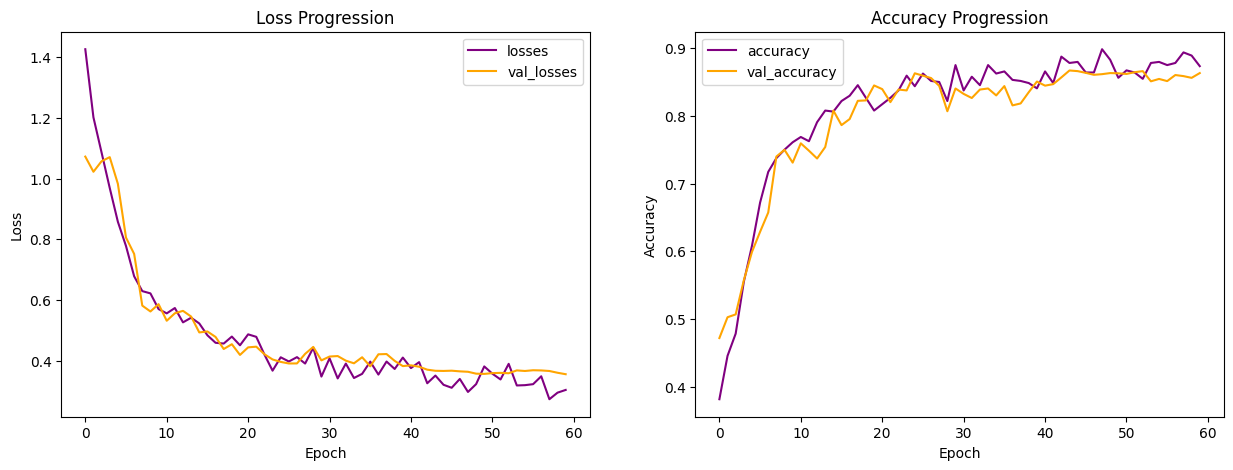

In [175]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

axes[0].plot(history['loss'], color='purple', label='losses')
axes[0].plot(history['val_loss'], color='orange', label='val_losses')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Progression')
axes[0].legend()

axes[1].plot(history['acc'], color='purple', label='accuracy')
axes[1].plot(history['val_acc'], color='orange', label='val_accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Progression')
axes[1].legend()
plt.show()

In [176]:
history_filepath = gdi.join_to_shared('notebooks/AL/models/ViT_mfcc.pkl')
with open(history_filepath, 'wb') as file:
  pkl.dump(history, file)

# See results

In [ ]:
sample_audio_num = 1095
sample_audio = val_frames[sample_audio_num]
sample_audio_aug = aug(sample_audio, 16000)
sample_spec = transform_frame(sample_audio, transform, transform_args)
sample_spec_aug = transform_frame(sample_audio_aug, transform, transform_args)

sample_audio_info = val_frame_df.iloc[sample_audio_num]
sample_audio_info

/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


data                                      val
primary_label                         eaywag1
primary_label_enc                           2
filename                 eaywag1/XC654684.ogg
filename_npy             eaywag1/XC654684.npy
rating                                   poor
type                                     call
type_enc                                    2
country                                    UZ
country_enc                                57
continent                                ASIA
continent_enc                               2
file_duration_s                        18.886
file_duration_samples                  302176
frame_length_s                            5.0
hop_length_s                              2.5
total_frames                                6
frame_id                                    4
Name: 1095, dtype: object

In [ ]:
Audio(sample_audio, rate=16000, autoplay=True)

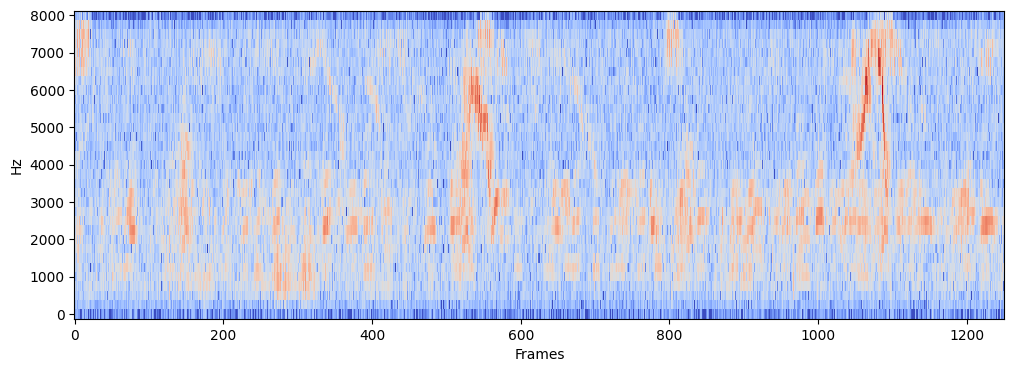

In [ ]:
plt.figure(figsize=(12,4))
librosa.display.specshow(
    sample_spec
    , x_axis='frames'
    , y_axis='linear'
    , sr=16000
    , hop_length=64
)

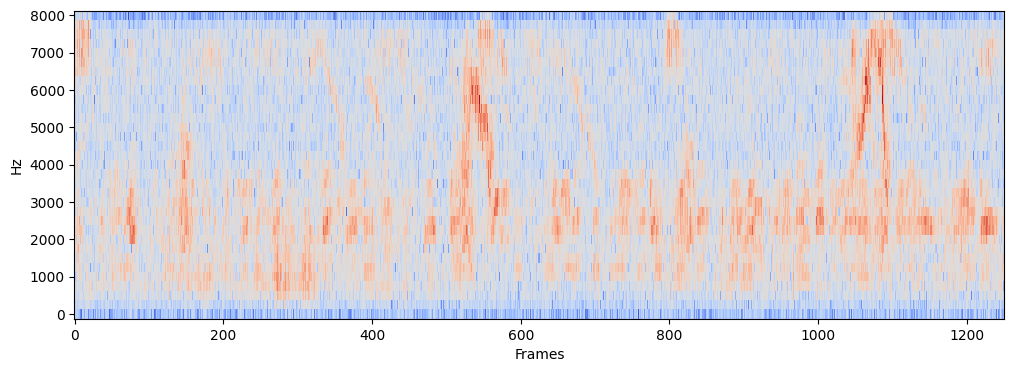

In [ ]:
plt.figure(figsize=(12,4))
librosa.display.specshow(
    np.array(tf.squeeze(add_noise_m((np.array([sample_spec])), training=True)))
    , x_axis='frames'
    , y_axis='linear'
    , sr=16000
    , hop_length=64
)

In [ ]:
sample_audio_info['primary_label_enc']

2

In [ ]:
layers.Softmax()(model2(np.array([sample_spec])))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5.1008686e-03, 7.0565799e-04, 9.9419349e-01]], dtype=float32)>

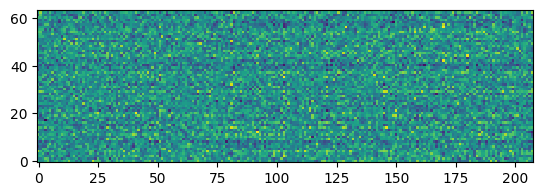

In [ ]:
plt.imshow(model2.get_layer('patch_encoder_1').get_weights()[3].T, aspect='equal', origin='lower', interpolation='none')

In [ ]:
# lstm_out = tf.squeeze(patch_enc_m2((np.array([sample_spec]))))
lstm_out = patch_enc_m2((np.array([sample_spec])))

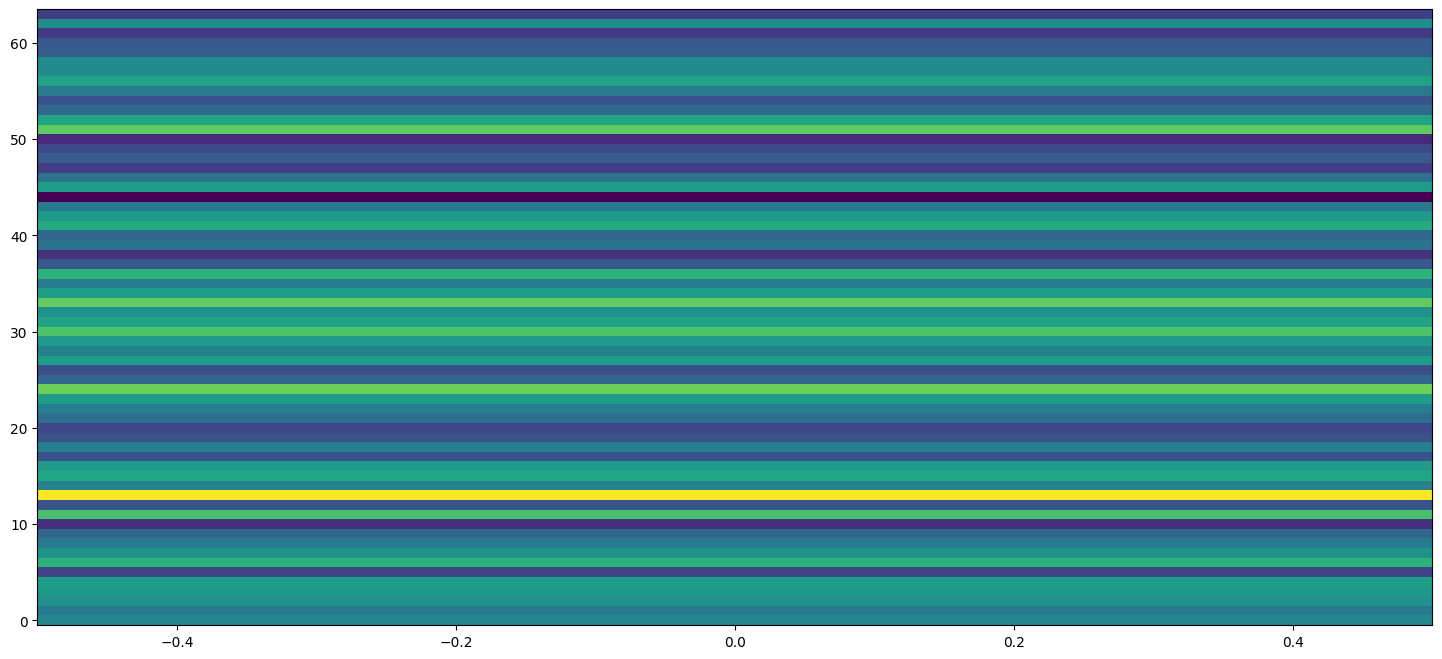

In [ ]:
plt.figure(figsize=(18,8))
plt.imshow(np.array(lstm_out).T, aspect='auto', origin='lower', interpolation='none')

In [ ]:
dense_out = tf.squeeze(dense_m((np.array([sample_spec_aug]))))

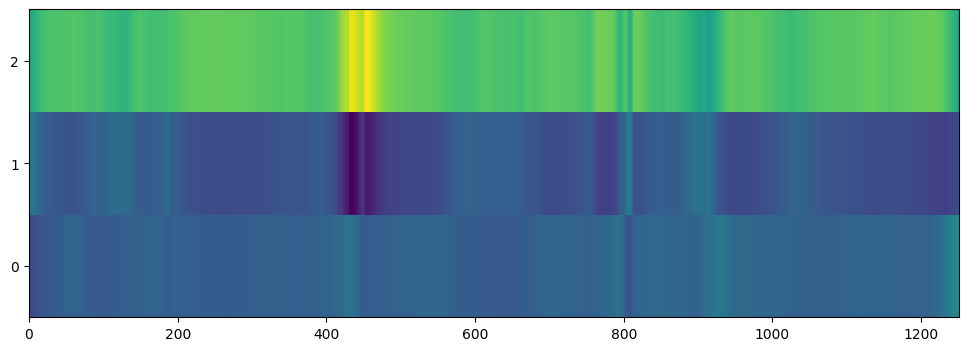

In [ ]:
plt.figure(figsize=(12,4))
plt.imshow(np.array(dense_out).T, aspect='auto', origin='lower', interpolation='none')
plt.yticks([0, 1, 2])
plt.show()

In [ ]:
mask_out = tf.squeeze(mask_dense_sm_m((np.array([sample_spec_aug]))))

<ipython-input-198-719fd9d2ee77>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.1e}'.format(y) for y in plt.gca().get_yticks()])


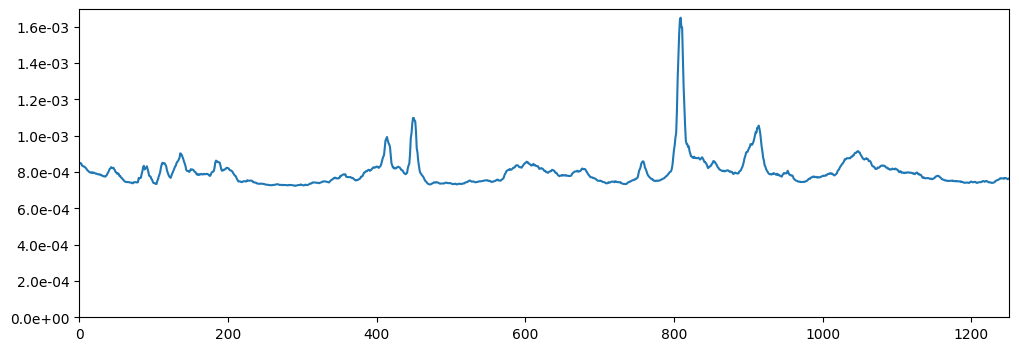

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(mask_out)
plt.xlim((0, 1251))
plt.ylim(bottom=0.)
plt.gca().set_yticklabels(['{:.1e}'.format(y) for y in plt.gca().get_yticks()])
plt.show()